In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as pickle

In [2]:
with open('frames_temp.dat', 'rb') as f:
    frames = pickle.load(f)

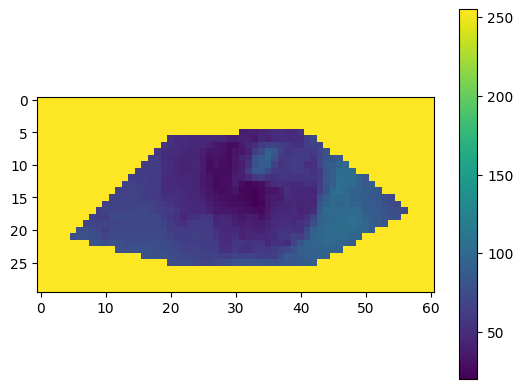

In [3]:
plt.imshow(frames[0]); plt.colorbar()

(array([45., 15., 43., 67., 41., 86., 17., 22., 49., 29.]),
 array([ 17. ,  28.7,  40.4,  52.1,  63.8,  75.5,  87.2,  98.9, 110.6,
        122.3, 134. ]),
 <BarContainer object of 10 artists>)

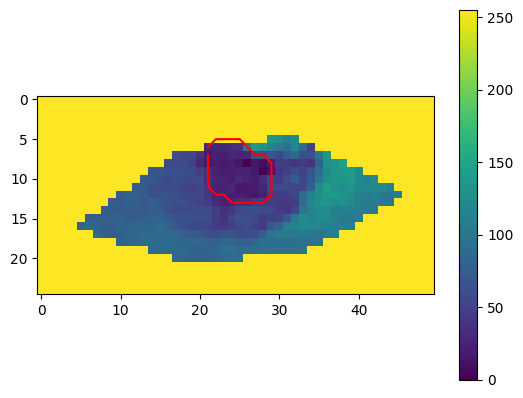

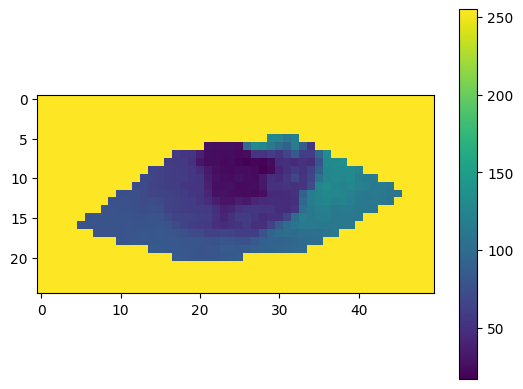

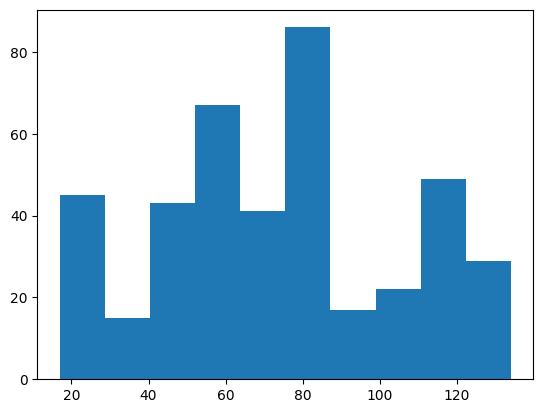

In [10]:
def image_processing(eye_frame, threshold):
    """Performs operations on the eye frame to isolate the iris

    Arguments:
        eye_frame (numpy.ndarray): Frame containing an eye and nothing else
        threshold (int): Threshold value used to binarize the eye frame

    Returns:
        A frame with a single element representing the iris
    """
    kernel = np.ones((3, 3), np.uint8)
    f_frame = cv2.bilateralFilter(eye_frame, 10, 15, 15)
    # new_frame = cv2.erode(new_frame, kernel, iterations=3)
    new_frame = cv2.threshold(f_frame, threshold, 255, cv2.THRESH_BINARY)[1]
    new_frame = cv2.morphologyEx(new_frame, cv2.MORPH_OPEN, kernel)
    new_frame = cv2.morphologyEx(new_frame, cv2.MORPH_CLOSE, kernel)

    return new_frame, f_frame

def detect_pupil(eye_frame, threshold):
    """Detects the iris and estimates the position of the iris by
    calculating the centroid.

    Arguments:
        eye_frame (numpy.ndarray): Frame containing an eye and nothing else
    """
    thr_frame, iris_frame = image_processing(eye_frame, threshold)
    contours, _ = cv2.findContours(thr_frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
    contours = sorted(contours, key=cv2.contourArea)
    return iris_frame, thr_frame, contours

pupil_size = np.array([])
for frame in frames:
    thr = np.percentile(frame[frame<255],10)
    # print(thr)

    f, n, c = detect_pupil(frame,thr)
    pupil_size = np.hstack((pupil_size, np.sum(n==0)))

plt.imshow(frame); plt.colorbar()
xc = [t[0][0] for t in c[0]]
yc = [t[0][1] for t in c[0]]
plt.plot(xc,yc,'r')

plt.figure()
plt.imshow(f); plt.colorbar()
plt.figure()
plt.hist(f[f<255])

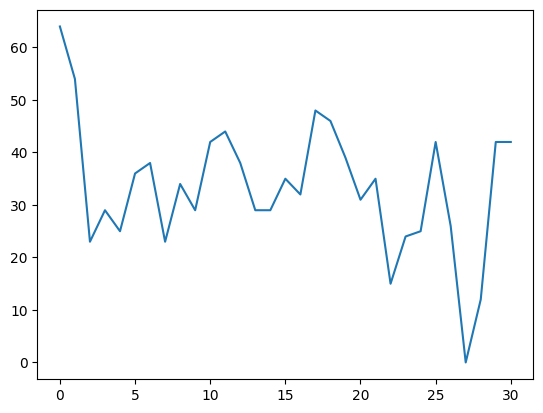

In [11]:
plt.plot(pupil_size)

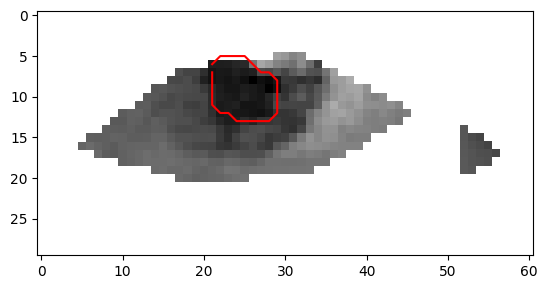

In [18]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

frames2show = [] # for storing the generated images
fig = plt.figure()
pupil_size = np.array([])
for frame in frames:
    thr = np.percentile(frame[frame<255],10)
    f, n, c = detect_pupil(frame,thr)
    # create frame
    temp = plt.imshow(frame, cmap='Greys_r',animated=True)
    xc = [t[0][0] for t in c[0]]
    yc = [t[0][1] for t in c[0]]
    temp = plt.plot(xc, yc, 'r')
    frames2show.append(temp)

ani = animation.ArtistAnimation(fig, frames2show, interval=250, blit=True,
                                repeat_delay=1000)
ani.save('pupil_detection.mp4')


HTML(ani.to_jshtml())